In [1]:
from __future__ import print_function, division, absolute_import

import GPy
import numpy as np
import matplotlib as mpl
import stage_opt
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from utilities import (plot_2d_gp, plot_3d_gp, plot_contour_gp,
                        linearly_spaced_combinations, sample_gp_function)

mpl.rcParams['figure.figsize'] = (40.0, 10.0)
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.markersize'] = 2

In [2]:
# # 设置输入安全限制数目n，则gp总数为n+1，第一个是效用函数
# safe_dim = 2

# # 设置测量不确定度，即可认为是误差方差
# noise_var = []

# # 设置kernel
# kernel = []
# for i in range(0, safe_dim + 1):
#     kernel.append(GPy.kern.RBF(input_dim=len(bounds), variance=2, lengthscale=1.0, ARD=True))
#     noise_var.append(0.005 ** 2)

# Measurement noise
noise_var = [0.05 ** 2, 1e-5, 1e-3]


# Bounds on the inputs variable
bounds = [(-10., 10.)]

# Define Kernel
kernel = GPy.kern.RBF(input_dim=len(bounds), variance=2., lengthscale=1.0, ARD=True)
kernel1 = kernel.copy()
kernel2 = kernel.copy()


# set of parameters
p_nums = 1000
parameter_set = linearly_spaced_combinations(bounds, p_nums)

# Initial safe point
index_0 = int(p_nums / 2)
x0 = np.zeros((1, len(bounds)))
x0[0][0] = parameter_set[index_0]

# Generate function with safe initial point at x=0
# 保证安全函数在给定点 parameter_set[500][:] 是安全的
def sample_safe_fun():
    fun = sample_gp_function(kernel, bounds, noise_var[0], 100)
    while True:
        fun2 = sample_gp_function(kernel1, bounds, noise_var[1], 100)
        if fun2(parameter_set[index_0][:], noise=False) > 1:
            break
    while True:
        fun3 = sample_gp_function(kernel2, bounds, noise_var[2], 100)
        if fun3(parameter_set[index_0][:], noise=False) > 1:
            break
            
    def combined_fun(x, noise=True):
        return np.hstack([fun(x, noise), fun2(x, noise), fun3(x, noise)])
    return combined_fun

In [3]:
# Define the objective function
fun = sample_safe_fun()

# # The statistical model of our objective function and safety constraint
y0 = fun(x0)
gp = GPy.models.GPRegression(x0, y0[:, 0, None], kernel, noise_var=noise_var[0])
gp2 = GPy.models.GPRegression(x0, y0[:, 1, None], kernel1, noise_var=noise_var[1])
gp3 = GPy.models.GPRegression(x0, y0[:, 2, None], kernel2, noise_var=noise_var[2])

# The optimization routine
opt = stage_opt.StageOpt([gp, gp2, gp3],index_0, parameter_set, [-np.inf, 0., 0.], lipschitz=0.1, threshold=0.1)
opt.lipschitz = 0.1
opt.beta(1)

2

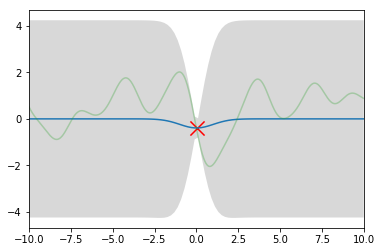

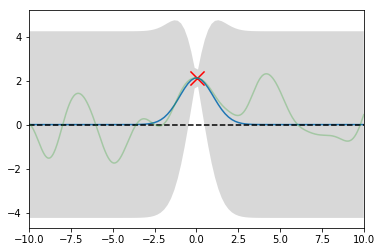

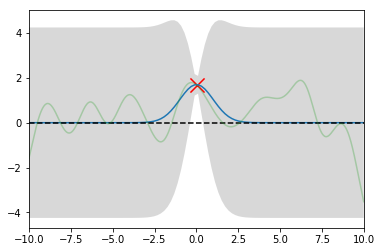

In [5]:
def plot(saferegion = None):
    # Plot the GP
    opt.plot(100,saferegion)
    # Plot the true function
    y = fun(parameter_set, noise=False)
    for manager, true_y in zip(mpl._pylab_helpers.Gcf.get_all_fig_managers(), y.T):
        figure = manager.canvas.figure
        figure.gca().plot(parameter_set, true_y, color='C2', alpha=0.3)
    
plot()

[-1.43143143  1.51151151]


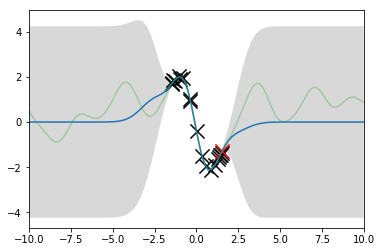

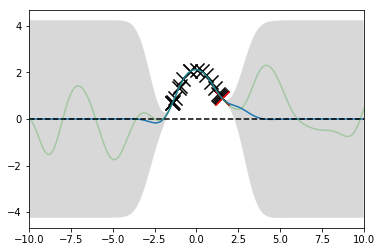

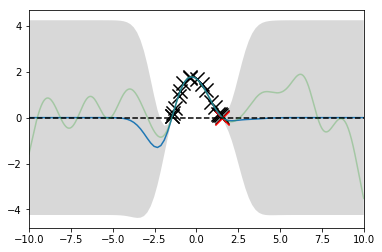

In [6]:
while opt.t < 20:
    # Obtain next query point
    x_next = opt.expansion()
    # Get a measurement from the real system
    y_meas = fun(x_next)
    # Add this to the GP model
    opt.add_new_data_point(x_next, y_meas)
    # print(x_next,y_meas,np.sum(opt.G),opt.bound)
    if (y_meas[0][1] < 0) or (y_meas[0][2] < 0):
        print('error')
        break

plot()
print(opt.bound)

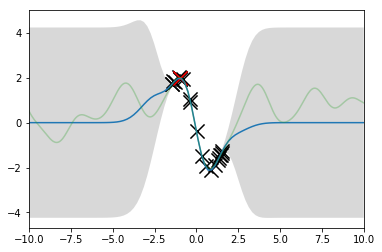

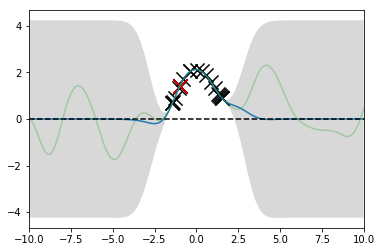

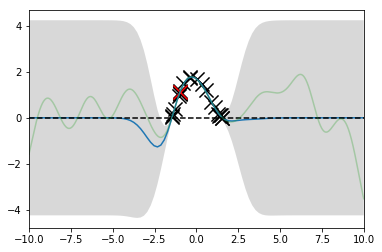

In [7]:
while opt.t < 25:
    # Obtain next query point
    x_next = opt.optimize()
    # Get a measurement from the real system
    y_meas = fun(x_next)
    # Add this to the GP model
    opt.add_new_data_point(x_next, y_meas)
    # print(x_next,y_meas,np.sum(opt.G),opt.bound)
    if (y_meas[0][1] < 0) or (y_meas[0][2] < 0):
        print('error')
        break
        
plot()

TypeError: 'module' object is not callable

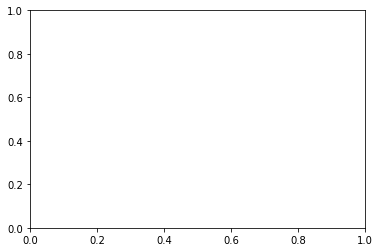

In [9]:
figure = plt.figure()
axis = figure.gca()

x = np.linspace(0, 1, 1000)
y1 = np(x>1)
y2 = np(x<2)
axis.fill_between(x,y1,y2)